# Data Preprocessing

In [1]:
import pandas as pd
import numpy as np
import os
import sys
import matplotlib.pyplot as plt
import seaborn as sns   

In [2]:
#load the dataset
df = pd.read_csv("./data/processed/shot_events.csv")

print(f"Dataset has {df.shape[0]} rows and {df.shape[1]} columns")

Dataset has 1494 rows and 45 columns


In [3]:
#globally set column display options
pd.options.display.max_columns = None
pd.options.display.max_rows = None

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1494 entries, 0 to 1493
Data columns (total 45 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     1494 non-null   object 
 1   index                  1494 non-null   int64  
 2   period                 1494 non-null   int64  
 3   timestamp              1494 non-null   object 
 4   minute                 1494 non-null   int64  
 5   second                 1494 non-null   int64  
 6   possession             1494 non-null   int64  
 7   location               1494 non-null   object 
 8   duration               1494 non-null   float64
 9   related_events         1494 non-null   object 
 10  type.id                1494 non-null   int64  
 11  type.name              1494 non-null   object 
 12  possession_team.id     1494 non-null   int64  
 13  possession_team.name   1494 non-null   object 
 14  play_pattern.id        1494 non-null   int64  
 15  play

In [5]:
# Display all duplicate rows
duplicate_rows = df[df.duplicated(keep=False)]
print(f"Number of duplicate rows: {len(duplicate_rows)}")
print("\nDuplicate rows:")
print(duplicate_rows)

Number of duplicate rows: 0

Duplicate rows:
Empty DataFrame
Columns: [id, index, period, timestamp, minute, second, possession, location, duration, related_events, type.id, type.name, possession_team.id, possession_team.name, play_pattern.id, play_pattern.name, team.id, team.name, player.id, player.name, position.id, position.name, shot.statsbomb_xg, shot.end_location, shot.key_pass_id, shot.type.id, shot.type.name, shot.outcome.id, shot.outcome.name, shot.technique.id, shot.technique.name, shot.body_part.id, shot.body_part.name, shot.freeze_frame, shot.first_time, shot.one_on_one, under_pressure, shot.aerial_won, shot.open_goal, shot.deflected, out, shot.saved_to_post, shot.follows_dribble, shot.saved_off_target, shot.redirect]
Index: []


In [6]:
# To see which rows are exactly identical
#print("\nGrouped duplicate rows with counts:")
#duplicate_counts = df.groupby(df.columns.tolist()).size().reset_index(name='count')
#print(duplicate_counts[duplicate_counts['count'] > 1])

What is xG? 

1. The acronym stands for Expected Goals. It represents the probability of a shot resulting in a goal
    * example: xG -> 0.2: likely to score 2 goals from 10 shots

How is xG calculated?
1. Parameters: 
    *   distance to goal
    *   angle to goal
    *   body part used
    *   type of assist/previous action(through ball, cross etc)
2. The model then calculates a probability of a goal between 0 and 1 
    *   1 means absolute certainty
    *   0 means no certainty


source: StatsBomb


To build a basic xG model

It Requires feaures that 
    a.  are known at the moment of the shot, 
    b.  affect the likelihood of scoring  
    c.  available consistently for all shots 
 


In [7]:
#check features available
print("Features available in the dataset:")
df.columns.tolist()

Features available in the dataset:


['id',
 'index',
 'period',
 'timestamp',
 'minute',
 'second',
 'possession',
 'location',
 'duration',
 'related_events',
 'type.id',
 'type.name',
 'possession_team.id',
 'possession_team.name',
 'play_pattern.id',
 'play_pattern.name',
 'team.id',
 'team.name',
 'player.id',
 'player.name',
 'position.id',
 'position.name',
 'shot.statsbomb_xg',
 'shot.end_location',
 'shot.key_pass_id',
 'shot.type.id',
 'shot.type.name',
 'shot.outcome.id',
 'shot.outcome.name',
 'shot.technique.id',
 'shot.technique.name',
 'shot.body_part.id',
 'shot.body_part.name',
 'shot.freeze_frame',
 'shot.first_time',
 'shot.one_on_one',
 'under_pressure',
 'shot.aerial_won',
 'shot.open_goal',
 'shot.deflected',
 'out',
 'shot.saved_to_post',
 'shot.follows_dribble',
 'shot.saved_off_target',
 'shot.redirect']

#### Features for the MVP model 

Feature selection guided by research:

1. shot.statsbomb_xg -> to train the model
2. location -> calculated distance and angle of shot
3. shot.body_part.name -> impacts quality(foot, head, etc)
4. shot.type.name -> open play, free kick etc
5. under_pressure -> impacts shot accuracy 



In [8]:
#create a copy of the dataframe for further processing
df_xg= df.copy()

#feature selection
df_xg = df_xg[['shot.statsbomb_xg','location','shot.body_part.name',
               'shot.type.name','under_pressure']]

#display the first few rows of the dataframe
print("First few rows of the dataset:")
print(df_xg.head(3))

First few rows of the dataset:
   shot.statsbomb_xg       location shot.body_part.name shot.type.name  \
0           0.023820   [92.6, 52.0]          Right Foot      Open Play   
1           0.014060  [114.0, 54.8]           Left Foot      Open Play   
2           0.033115   [93.4, 44.5]          Right Foot      Open Play   

  under_pressure  
0            NaN  
1            NaN  
2            NaN  


In [9]:
#check for missing values (percentage)
df_xg.isna().mean()*100

shot.statsbomb_xg       0.000000
location                0.000000
shot.body_part.name     0.000000
shot.type.name          0.000000
under_pressure         84.069612
dtype: float64

In [10]:
#examine under_pressure feature
print("Unique values in 'under_pressure' feature:")
print(df_xg['under_pressure'].unique())

Unique values in 'under_pressure' feature:
[nan True]


The feature 'under_pressure' is a binary feature; indicating whether the shot was underpressure (True) or not underpressure (False).

Why is the data missing?
1.  It appears data collection intentionally recorded 'True' when the shot was under pressure. 
2.  It did not record a value for when it was not under pressure

What type of Missing Data is This?
*   MNAR (Missing not at Random) ->
    *   missingness depends on the value itself
    *   missing due to how the data was collected
    *   NaN means -> "no pressure" (safe to treat as False)

Approach to handle missing value
*   Convert to binary values
    *   True -> 1
    *   NaN -> 0


In [11]:
#manage missing values
df_xg['under_pressure']= df_xg['under_pressure'].fillna(0).astype(int)

#convert 'True to 1'
df_xg['under_pressure'] = df_xg['under_pressure'].replace(True, 1)

#confirm changes
print("Unique values in 'under_pressure' after conversion:")
print(df_xg['under_pressure'].unique())

#check missing values again
print("Missing values after processing:")   
print(df_xg.isna().mean() * 100)


Unique values in 'under_pressure' after conversion:
[0 1]
Missing values after processing:
shot.statsbomb_xg      0.0
location               0.0
shot.body_part.name    0.0
shot.type.name         0.0
under_pressure         0.0
dtype: float64


In [12]:
#check data types
print("Data types of the features:")
print(df_xg.dtypes) 

Data types of the features:
shot.statsbomb_xg      float64
location                object
shot.body_part.name     object
shot.type.name          object
under_pressure           int32
dtype: object


### Feature: Location

Closer look:

1.  The feature location is an array with two sets of values.
2.  The values represent x and y coordinates for shot take (source StatsBomb)
3.  The football pitch is a plane equal to the product of x=120 and y =80
4.  The center of the goal is y=40

In order to calculate xG:
1.  Calculate the distance from the center of goal
2.  Calcualte the angle of the shot from goal 
    a.  shot angle confined to width of the goal (top and bottom y coordinates of the goal frame)
3. The law of cosine will be used to calculate shot angle and 
4.  Pythogas theorem used to calculate shot distance


# Feature engineering: extract x and y coordinates

In [ ]:
sys.path.append("C:/Users/On3B3/OneDrive/Documents/Programming_Projects/xG_Model/src")
#import user-defined Class for shot calculations
from features import ShotCalculations


In [23]:
import ast

#extraxt x and y coordinates from the 'location' column
df_xg['x']= df_xg['location'].apply(lambda x: ast.literal_eval(x)[0])
df_xg['y']= df_xg['location'].apply(lambda x: ast.literal_eval(x)[1])

#convert 'x' and 'y' to float
df_xg['x'] = df_xg['x'].astype(float)
df_xg['y'] = df_xg['y'].astype(float)


In [24]:
#calculate the distance from the goal
def calculate_shot_features(row):
    #create instance for each individual shot

    shot= ShotCalculations(x=row['x'], y=row['y'])
    return pd.Series({
        'shot_distance': shot.calculate_shot_distance(),
        'shot_angle': shot.calculate_shot_angle()
    })
    
#apply the function to each row
shot_features = df_xg.apply(calculate_shot_features, axis=1)

#add new features to the dataframe
df_xg = pd.concat([df_xg, shot_features], axis=1)

#verify the new features
print(df_xg[['x','y','shot_distance','shot_angle']].head(3))

       x     y  shot_distance  shot_angle
0   92.6  52.0      29.912539    0.223755
1  114.0  54.8      15.969972    0.179792
2   93.4  44.5      26.977954    0.266085


In [ ]:
#rename columns for clarity
df_xg.columns=['shot_xg','location','body_part','shot_type','under_pressure',
       'x','y','shot_distance','shot_angle']

#verify changes
print(df_xg.columns.tolist())

['shot_xg',
 'location',
 'body_part',
 'shot_type',
 'under_pressure',
 'x',
 'y',
 'shot_distance',
 'shot_angle']

In [28]:
df_xg.head(3)

,shot_xg,location,body_part,shot_type,under_pressure,x,y,shot_distance,shot_angle
0,0.023820,"[92.6, 52.0]",Right Foot,Open Play,0,92.6,52.0,29.912539,0.223755
1,0.014060,"[114.0, 54.8]",Left Foot,Open Play,0,114.0,54.8,15.969972,0.179792
2,0.033115,"[93.4, 44.5]",Right Foot,Open Play,0,93.4,44.5,26.977954,0.266085


In [32]:
#convert under_pressure to categorical
df_xg['under_pressure'] = df_xg['under_pressure'].astype('category')

#verify the conversion
print(f"under_pressure data type: {df_xg['under_pressure'].dtypes}")

under_pressure data type: category


In [33]:
#check for missing values again
print("Missing values after all processing:")
print(df_xg.isna().mean() * 100)

Missing values after all processing:
shot_xg           0.0
location          0.0
body_part         0.0
shot_type         0.0
under_pressure    0.0
x                 0.0
y                 0.0
shot_distance     0.0
shot_angle        0.0
dtype: float64


In [48]:
# Save the processed DataFrame to a CSV file
output_path = "./data/processed/shot_events_processed.csv"
df_xg.to_csv(output_path, index=False)

# Data Visualization

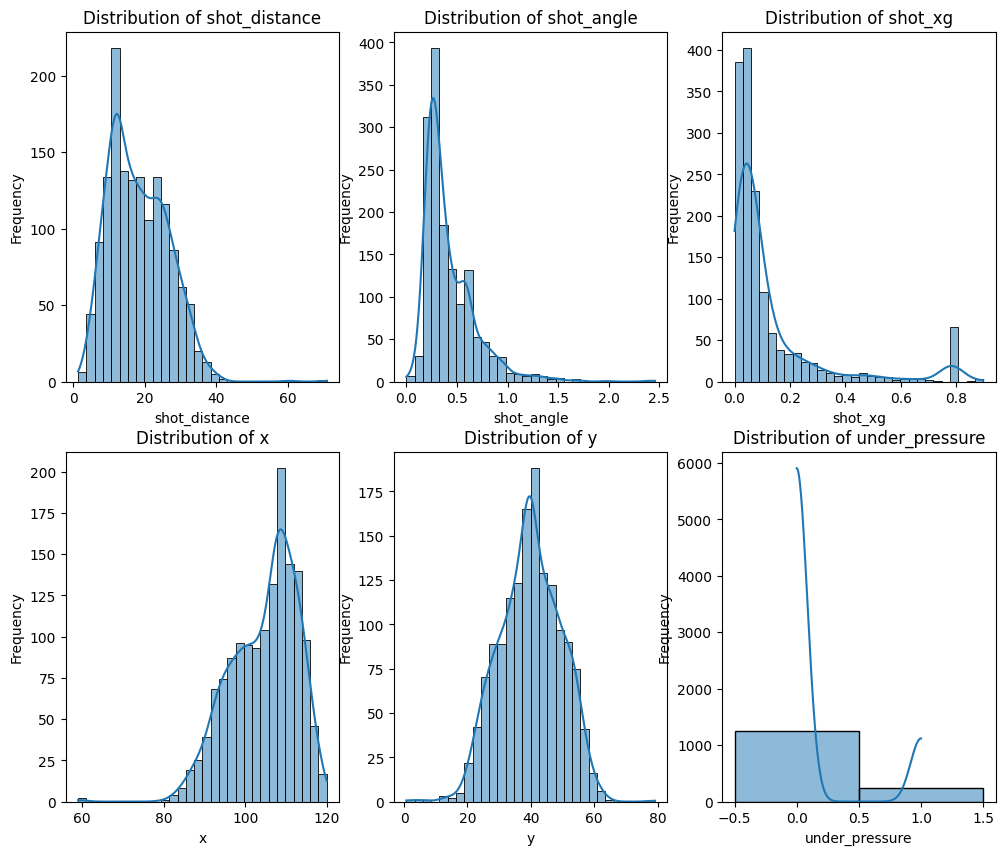

In [ ]:
# 1. Histogram: Feature Distributions
features = [ 'shot_distance', 'shot_angle', 'shot_xg', 'x', 'y', 'under_pressure']

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 10))
axes = axes.flatten()
for i, feature in enumerate(features):
    sns.histplot(df_xg[feature], bins=30, kde=True, ax=axes[i])
    axes[i].set_title(f'Distribution of {feature}')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Frequency')

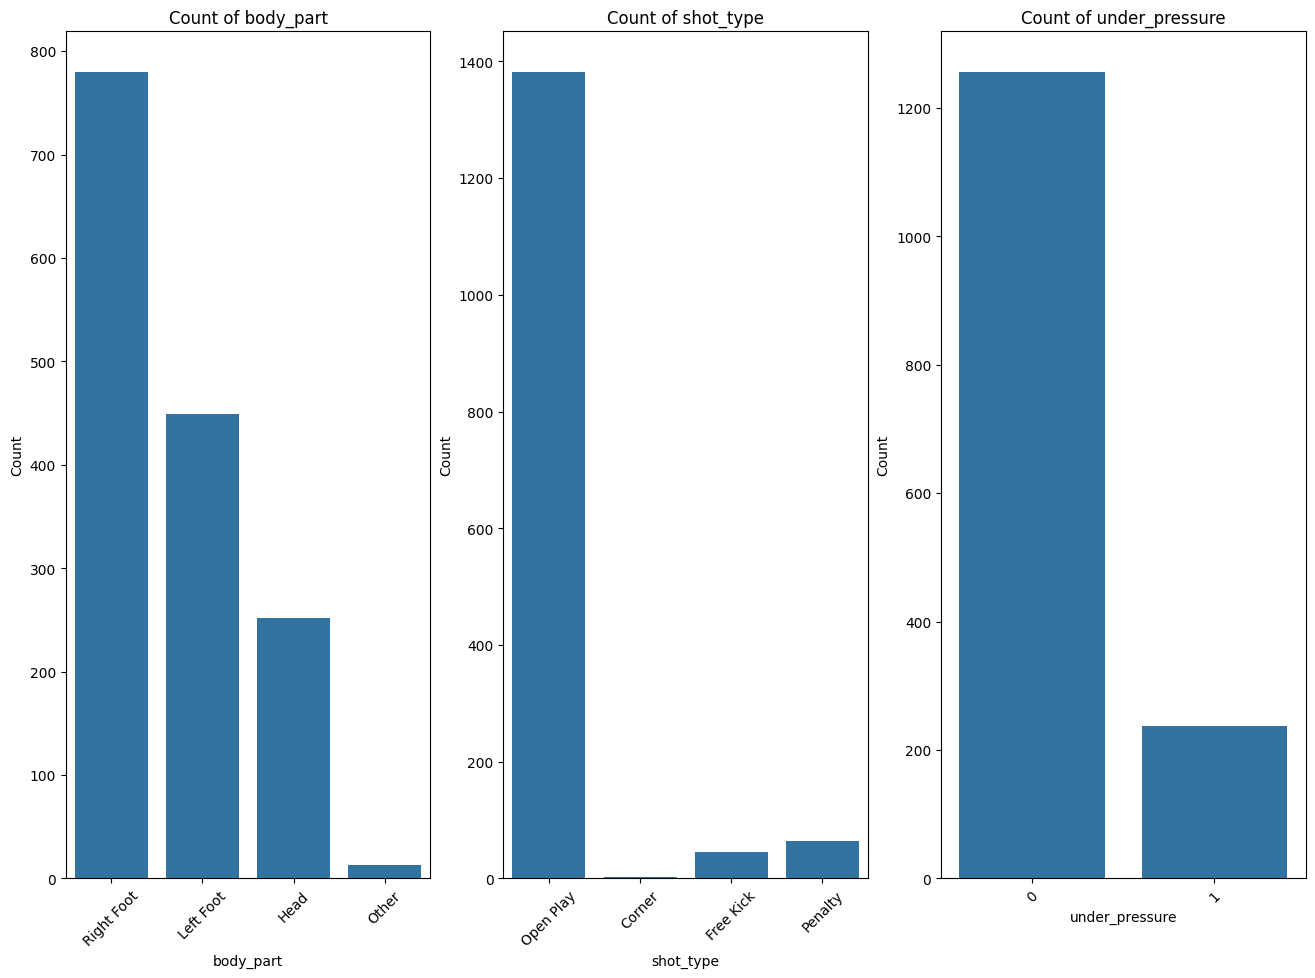

In [56]:
#2. Bar Chart: Categorical Features
categorical_features = ['body_part', 'shot_type', 'under_pressure']
fig, axes = plt.subplots(nrows=1, ncols=len(categorical_features), figsize=(16, 11))
for i, feature in enumerate(categorical_features):
    sns.countplot(data=df_xg, x=feature, ax=axes[i])
    axes[i].set_title(f'Count of {feature}')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Count')
    axes[i].tick_params(axis='x', rotation=45)

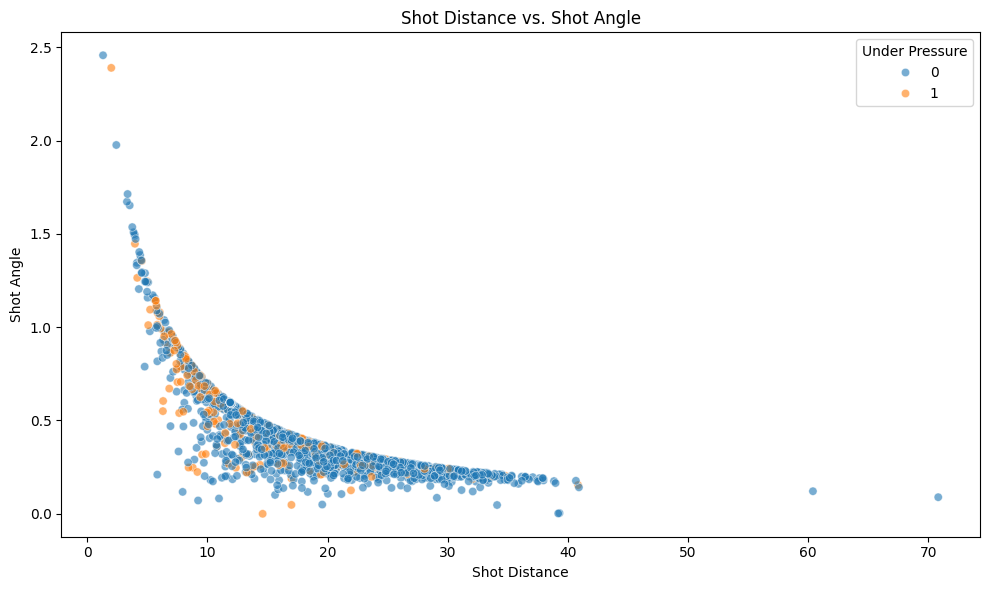

In [57]:
#3. Scatter Plot: Shot Distance vs. Shot Angle
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_xg, x='shot_distance', y='shot_angle', hue='under_pressure', alpha=0.6)
plt.title('Shot Distance vs. Shot Angle')
plt.xlabel('Shot Distance')
plt.ylabel('Shot Angle')
plt.legend(title='Under Pressure')
plt.tight_layout()

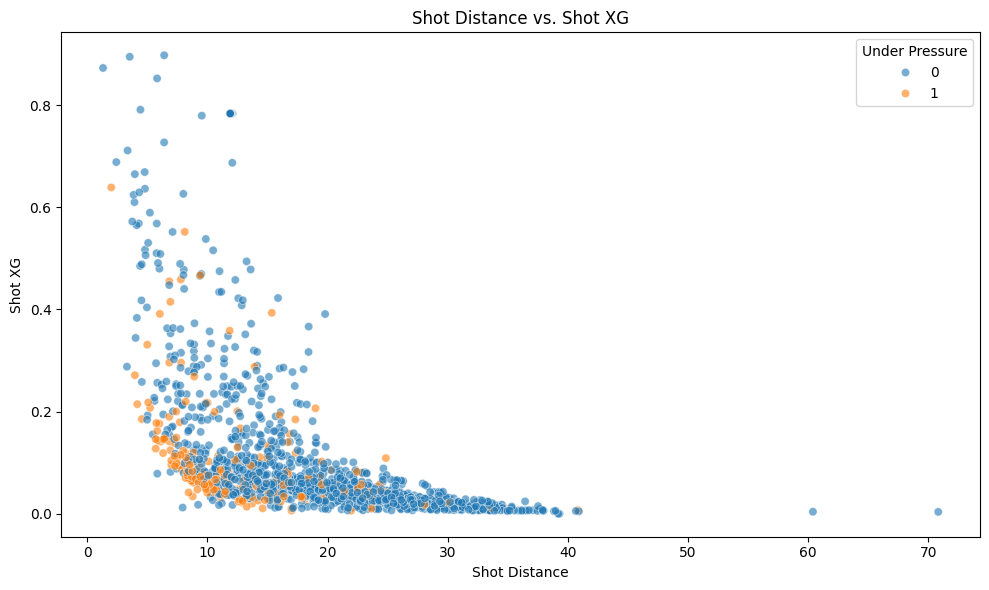

In [58]:
#4. Scatter Plot: Shot Distance vs. Shot XG
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_xg, x='shot_distance', y='shot_xg', hue='under_pressure', alpha=0.6)
plt.title('Shot Distance vs. Shot XG')
plt.xlabel('Shot Distance')
plt.ylabel('Shot XG')
plt.legend(title='Under Pressure')
plt.tight_layout()

In [ ]:
def draw_pitch(ax=None, pitch_length=120, pitch_width=80):
    """Function to draw a football pitch with specified dimensions."""
    if ax is None:
        fig, ax = plt.subplots(figsize=(12, 8))
    
    # Pitch Outline & Centre Line
    ax.plot([0, 0, pitch_length, pitch_length, 0], [0, pitch_width, pitch_width, 0, 0], color="black")
    ax.plot([pitch_length/2, pitch_length/2], [0, pitch_width], color="black")
    
    # Left Penalty Area
    ax.plot([18, 18, 0, 0, 18], [62, 18, 18, 62, 62], color="black")
    # Right Penalty Area
    ax.plot([pitch_length, pitch_length, pitch_length-18, pitch_length-18, pitch_length], 
            [62, 18, 18, 62, 62], color="black")
    
    # Left 6-yard Box
    ax.plot([6, 6, 0, 0, 6], [50, 30, 30, 50, 50], color="black")
    # Right 6-yard Box
    ax.plot([pitch_length, pitch_length, pitch_length-6, pitch_length-6, pitch_length],
            [50, 30, 30, 50, 50], color="black")
    
    # Centre Circle
    centre_circle = plt.Circle((pitch_length/2, pitch_width/2), 10, color="black", fill=False)
    ax.add_patch(centre_circle)
    
    # Penalty Spots
    ax.plot([12, pitch_length-12], [pitch_width/2, pitch_width/2], marker='o', color='black', linestyle='None')
    
    # Remove axis labels and ticks
    ax.set_xticks([])
    ax.set_yticks([])
    
    # Set limits to the pitch size
    ax.set_xlim(0, pitch_length)
    ax.set_ylim(0, pitch_width)
    
    ax.set_aspect('equal')
    return ax

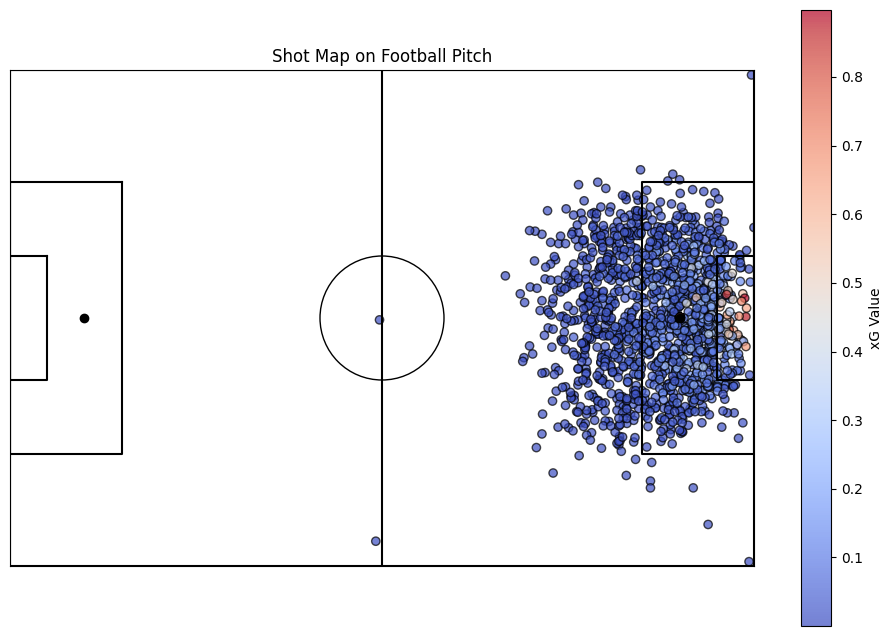

In [63]:
#5. Shot Map on Football Pitch (Scatter Plot of 'x' and 'y')
fig, ax = plt.subplots(figsize=(12, 8))
ax = draw_pitch(ax)

# Plot shots colored by xG
sc = ax.scatter(df_xg['x'], df_xg['y'], c=df_xg['shot_xg'], cmap='coolwarm', alpha=0.7, edgecolors='k')

plt.colorbar(sc, label='xG Value')
plt.title('Shot Map on Football Pitch')
plt.show()

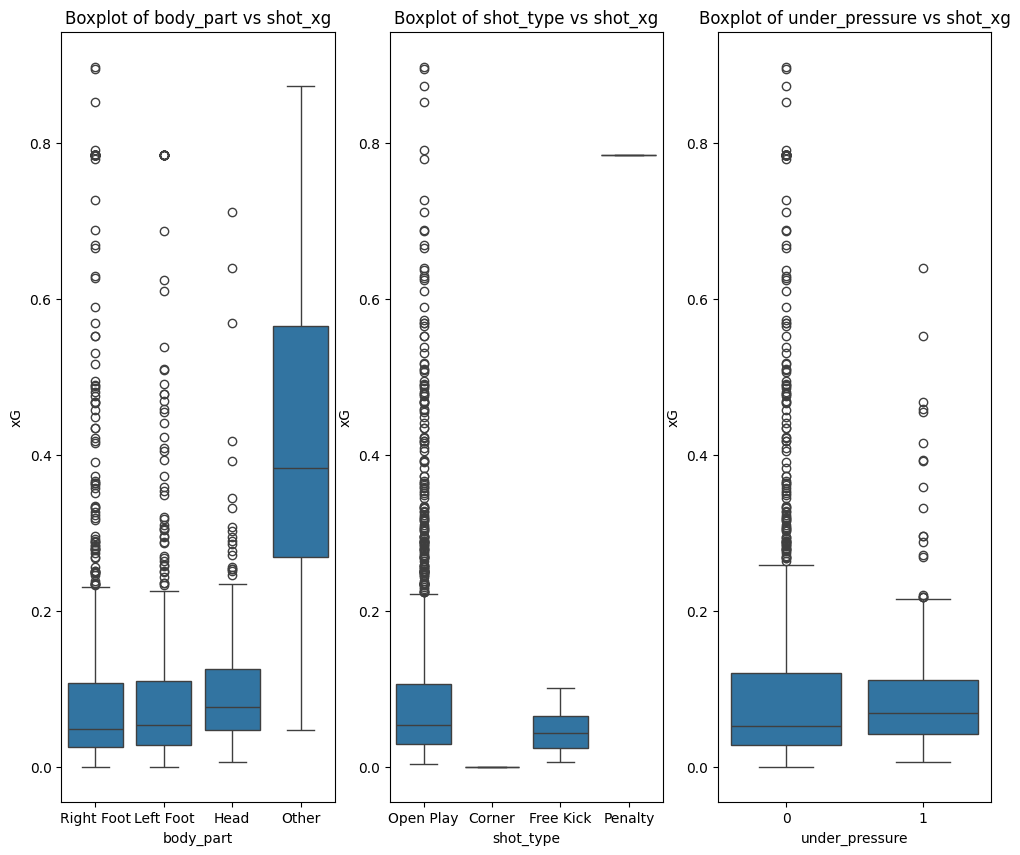

In [ ]:
#6. Boxplot: Feature vs. Shot XG
features = [ 'body_part', 'shot_type', 'under_pressure']

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 10))
axes = axes.flatten()
for i, feature in enumerate(features):
    sns.boxplot(x=df_xg[feature],y=df_xg['shot_xg'],data=df_xg, ax=axes[i])
    axes[i].set_title(f'Boxplot of {feature} vs shot_xg')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('xG')

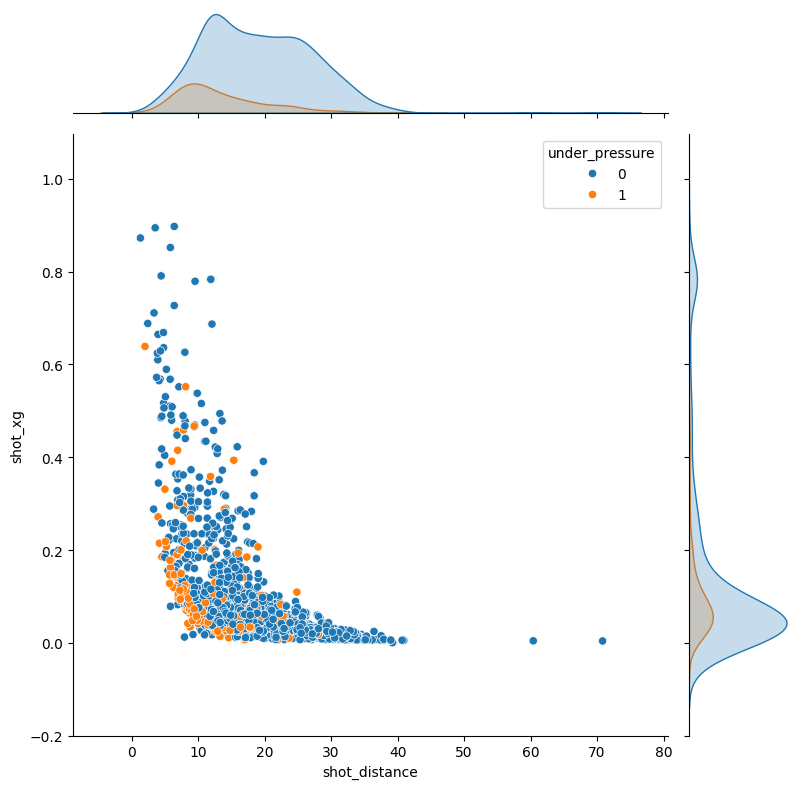

In [68]:
#7. Joint Plot: Shot Distance vs. Shot XG
sns.jointplot(data=df_xg, x='shot_distance', y='shot_xg', kind='scatter', hue='under_pressure', height=8)